# Variational Quantum Classifier (VQC) Best Parameter Training

The notebook trains a VQC, based on best parameters found in grid search

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [48]:
# imports
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import clear_output

import os
import time

# import data class
from utilities.dataset_utils import DiabetesData

# sampling for dataset balance
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import shuffle

# import metrics for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# qiskit imports
# circuit transpiler
from qiskit import transpile

# algorithm
from qiskit_machine_learning.algorithms.classifiers import VQC

# feature map
from qiskit.circuit.library import z_feature_map

# ansatz
from qiskit.circuit.library import real_amplitudes

# optimizer
from qiskit_machine_learning.optimizers import COBYLA

# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

In [49]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [50]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [51]:
# feature map
feature_map = z_feature_map(feature_dimension=dataset.get_num_features(), reps=2, entanglement='linear')
feature_map = transpile(feature_map, backend=backend, optimization_level=3) # transpile to backend

In [52]:
# ansatz
ansatz = real_amplitudes(num_qubits=dataset.get_num_features(), reps=3, entanglement='full')
ansatz = transpile(ansatz, backend=backend, optimization_level=3) # transpile to backend

In [53]:
# callback graph
# init list to store objective function values
objective_func_vals = []

# larger size for graph
plt.rcParams["figure.figsize"] = (12, 6)

# callback function to plot objective function value (updates after each iteration)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective Function Value")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(objective_func_vals)
    plt.show()

In [54]:
# optimizer
optimizer = COBYLA(maxiter=500)

In [55]:
# sampler
sampler = Sampler.from_backend(backend)

In [56]:
# create the VQC instance
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


### Model Fit on Simulator

In [57]:
# get training and testing data
X_train, X_test, y_train, y_test = dataset.preprocess_data_ranged()

In [58]:
print(Counter(y_train))

Counter({np.int64(0): 350, np.int64(1): 187})


In [59]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [60]:
print(Counter(y_train_balanced))

Counter({np.int64(1): 350, np.int64(0): 350})


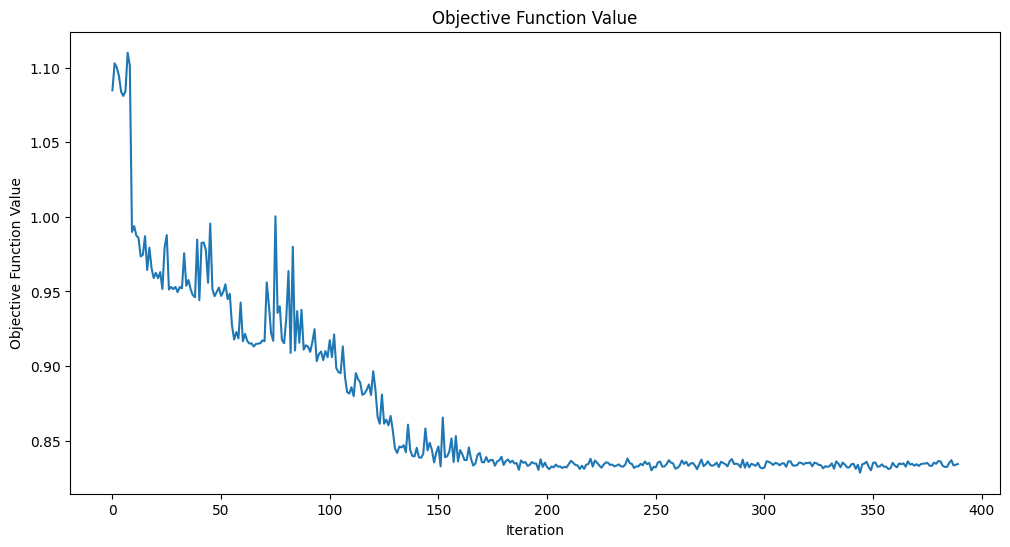

Training Time: 1600 secs
[1.0847867738172001, 1.1028794079488828, 1.1001302176441898, 1.0945026888128275, 1.083866155291614, 1.0810322349721453, 1.0841799582955858, 1.1099922873550723, 1.1014169783704408, 0.9898445098020144, 0.9938026989025879, 0.9874351749208616, 0.9858624818876732, 0.9734603637986314, 0.9745691123363673, 0.9870178927717913, 0.9643921202088798, 0.9793353790048703, 0.965626053837906, 0.9589872167329354, 0.9624522972150497, 0.9588048749295396, 0.9629568307416053, 0.9516089804443102, 0.9795096806247513, 0.9877304493314386, 0.9513181881189536, 0.9529570460995126, 0.9515980075504942, 0.9530184677775451, 0.9495182794475425, 0.9529904164237872, 0.9520306404693606, 0.9755731657423694, 0.9538358337269777, 0.9576273856653328, 0.9513092185198851, 0.9474650087361233, 0.9460860311300185, 0.9847647010381906, 0.944107728295271, 0.9825667728031316, 0.9827657999827677, 0.9777479792110954, 0.9557867834158174, 0.9954972814333707, 0.9515224793592123, 0.9468036202830727, 0.949711435572189

In [61]:
# time how long it takes to train
start = time.time()

# fit the model
vqc = vqc.fit(X_train_balanced, y_train_balanced)

end = time.time()
elapsed = end - start

# print training time
print(f"Training Time: {round(elapsed)} secs")

# print objective func val at each iteration
print(objective_func_vals)

### VQC Evaluation

In [62]:
# reset rcParams to default
plt.rcParams["figure.figsize"] = (6,4)

In [63]:
train_score = vqc.score(X_train_balanced, y_train_balanced)
test_score = vqc.score(X_test, y_test)
train_score, test_score

(0.7142857142857143, 0.70995670995671)

In [64]:
# predict
y_pred = vqc.predict(X_test)

In [65]:
# confusion matrix
def conf_matrix(y_test, y_pred):
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix: VQC')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [66]:
# accuracy score
accuracy = accuracy_score(y_test, y_pred)

In [67]:
# classification report
report = classification_report(y_test, y_pred, zero_division=0, output_dict=False)

Accuracy: 0.70995670995671
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.79       150
           1       0.60      0.51      0.55        81

    accuracy                           0.71       231
   macro avg       0.68      0.66      0.67       231
weighted avg       0.70      0.71      0.70       231



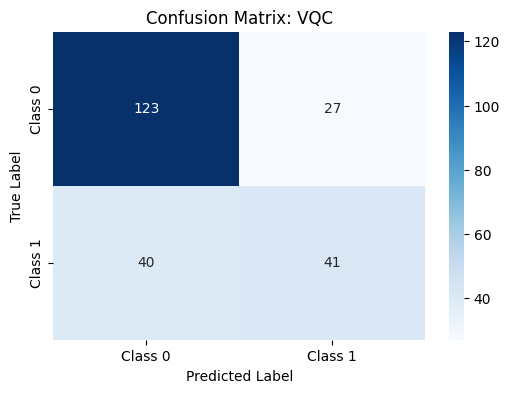

In [68]:
# print metrics
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
conf_matrix(y_test, y_pred)

### Save Model

In [69]:
# path to save model
model_path = os.path.join(os.getcwd(), '..', '..', '..', 'models', 'qml-simulator')

# create model directory if it doesn't exist
os.makedirs(model_path, exist_ok=True)

# create model file
model_file = os.path.join(model_path, 'vqc_best_params.model')

# save model
vqc.save(model_file)
print(f'Model saved to {model_file}')

Model saved to /home/barra-white/college/qml-explainability-by-parts/training/qml-best-params/vqc/../../../models/qml-simulator/vqc_best_params.model
